реализуем нормализацию данных

In [51]:
def z_score_normalization(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    stds[stds == 0] = 1e-8

    normalized_X = (X - means) / stds
    return normalized_X, means, stds

def min_max_normalization(X, new_min=0, new_max=1):

    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)

    range_values = maxs - mins
    range_values[range_values == 0] = 1e-8

    normalized_X = (X - mins) / range_values
    normalized_X = normalized_X * (new_max - new_min) + new_min
    return normalized_X, mins, maxs

реализуем класс модели линейной регрессии

In [52]:
class LinearRegressionModel:
    def __init__(self):
        self.weights = None

    def fit(self, X, y, method="analytical", learning_rate=0.01, epochs=1000):

        X = self.add_bias(X)
        n_samples, n_features = X.shape

        if method == "analytical":
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y

        elif method == "gradient":
            self.weights = np.zeros(n_features)
            for _ in range(epochs):
                gradients = (1 / n_samples) * (X.T @ (X @ self.weights - y))
                self.weights -= learning_rate * gradients

        elif method == "stochastic":
            self.weights = np.zeros(n_features)
            for _ in range(epochs):
                for i in range(n_samples):
                    random_index = np.random.randint(n_samples)
                    xi = X[random_index:random_index + 1]
                    yi = y[random_index:random_index + 1]
                    gradients = 2 * xi.T @ (xi @ self.weights - yi)
                    self.weights -= learning_rate * gradients.flatten()

        else:
            raise ValueError("Неверный метод. Выберите 'analytical', 'gradient' или 'stochastic'.")

    def predict(self, X):
        X = self.add_bias(X)
        return X @ self.weights

    def add_bias(self, X):
        return np.c_[np.ones(X.shape[0]), X]

реализуем оценки

In [53]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true))**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        raise ValueError("Все значения y_true равны нулю, MAPE не определен.")

    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

In [54]:
def k_fold_cross_validation(X, y, model, k=5):
    n_samples = len(y)
    fold_size = n_samples // k
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    mse_scores = []

    for i in range(k):
        test_start = i * fold_size
        test_end = (i + 1) * fold_size if i < k - 1 else n_samples
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate((indices[:test_start], indices[test_end:]))

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = np.mean((y_test - y_pred) ** 2)
        mse_scores.append(mse)

    return np.mean(mse_scores)

def leave_one_out_cross_validation(X, y, model):
    n_samples = len(y)
    mse_scores = []

    for i in range(n_samples):
        test_index = i
        train_indices = np.delete(np.arange(n_samples), i)

        # Разделение данных
        X_train, X_test = X[train_indices], X[test_index:test_index + 1]
        y_train, y_test = y[train_indices], y[test_index:test_index + 1]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = np.mean((y_test - y_pred) ** 2)
        mse_scores.append(mse)

    return np.mean(mse_scores)

Теперь проведём EDA.

Посмотрим на типы данных, пропуски, основные показатели по данным.

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

df = pd.read_csv('train.csv')

print(df.isna().sum() / len(df) * 100)

ApplicationDate               4.810747
Age                           4.810747
AnnualIncome                  4.810747
CreditScore                   9.358265
LoanAmount                    9.358265
LoanDuration                  4.810747
MaritalStatus                 4.810747
NumberOfDependents            4.810747
HomeOwnershipStatus           4.810747
MonthlyDebtPayments           9.358265
CreditCardUtilizationRate     4.810747
NumberOfOpenCreditLines       4.810747
NumberOfCreditInquiries       4.810747
DebtToIncomeRatio             4.810747
BankruptcyHistory             9.358265
LoanPurpose                   9.358265
PreviousLoanDefaults          4.810747
PaymentHistory                4.810747
LengthOfCreditHistory         4.810747
SavingsAccountBalance         4.810747
CheckingAccountBalance        9.358265
TotalAssets                   9.358265
TotalLiabilities              4.810747
MonthlyIncome                 4.810747
UtilityBillsPaymentHistory    4.810747
JobTenure                

In [56]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

In [57]:
pd.set_option('display.max_columns', None)
print(df.describe())

                Age   AnnualIncome  CreditScore     LoanAmount  LoanDuration  \
count  10487.000000   10487.000000  9986.000000    9986.000000  10487.000000   
mean      39.850386  131587.872127   678.082716   29874.218306     53.439878   
std       11.614132  115791.941909   175.192486   27705.509722     24.493562   
min       18.000000   15000.000000   300.000000    1063.000000     12.000000   
25%       32.000000   20959.500000   550.000000   12658.000000     36.000000   
50%       40.000000   89015.000000   722.500000   21828.500000     48.000000   
75%       48.000000  257025.000000   850.000000   37158.000000     60.000000   
max       80.000000  748508.000000   850.000000  418997.000000    120.000000   

       NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
count        10487.000000          9986.000000               10487.000000   
mean             1.568323           546.458642                   0.284397   
std              1.418684           501.981888  

заполним пропуски по числовым признакам средними значениями, по категориальным - модой. при этом признак ApplicationDate уберём вообще.

In [58]:
df = df.drop(columns=['ApplicationDate'], errors='ignore')

numeric_features = df.select_dtypes(include="number").columns
categorical_features = df.select_dtypes(include="object").columns
df_filled = df.copy()
df_filled[numeric_features] = df_filled[numeric_features].fillna(df_filled[numeric_features].mean())
for feature in categorical_features:
    df_filled[feature] = df_filled[feature].fillna(df_filled[feature].mode()[0])

print(df_filled.isna().sum())


Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate              0
InterestRate                  0
MonthlyL

In [59]:
for col in categorical_features:
    unique = df_filled[col].unique()
    print(f"{col}: ")
    print(unique)

MaritalStatus: 
['Divorced' 'Widowed' 'Married' 'Single']
HomeOwnershipStatus: 
['Rent' 'Mortgage' 'Other' 'Own']
LoanPurpose: 
['Education' 'Home' 'Debt Consolidation' 'Auto' 'Other']
EmploymentStatus: 
['Employed' 'Self-Employed' 'Unemployed']
EducationLevel: 
['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate']


некоторые категориальные признаки преобразуем к числовым

In [60]:
home_ownership = {"Own" : 0, "Mortgage" : 1, "Rent" : 2, "Other" : 3}
employment_status = {"Employed" : 0, "Self-Employed" : 1, "Unemployed" : 2}
education_level = {"Doctorate" : 0, "Master" : 1, "Bachelor" : 2, "Associate" : 3, "High School" : 4}

df_filled["HomeOwnershipStatus"] = df_filled["HomeOwnershipStatus"].map(home_ownership)
df_filled["EmploymentStatus"] = df_filled["EmploymentStatus"].map(employment_status)
df_filled["EducationLevel"] = df_filled["EducationLevel"].map(education_level)

посмотрим на распределения числовых признаков

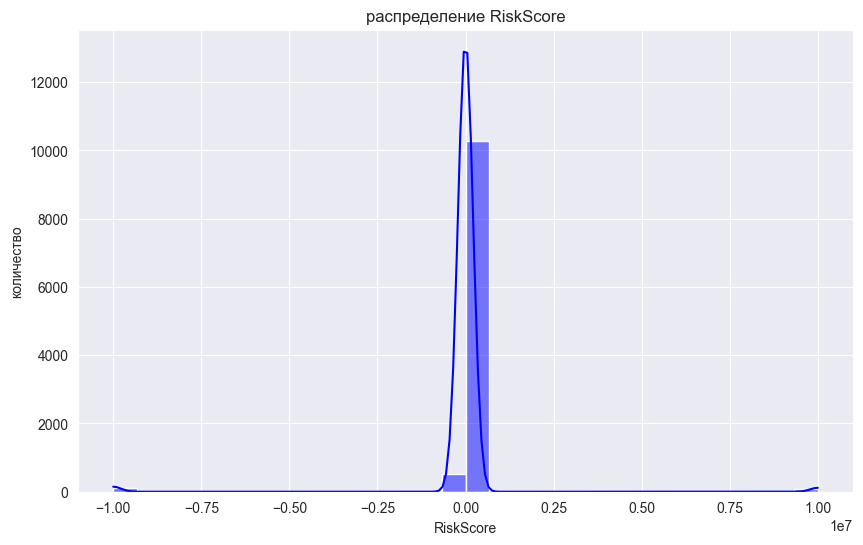

In [61]:
lower_bound = df_filled['RiskScore'].min()
upper_bound = df_filled['RiskScore'].max()

filtered_data = df_filled[(df_filled['RiskScore'] >= lower_bound) & (df_filled['RiskScore'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['RiskScore'], bins=30, kde=True, color='blue')
plt.title('распределение RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('количество')
plt.show()


0 Age
1 AnnualIncome
2 CreditScore
3 LoanAmount
4 LoanDuration
5 NumberOfDependents
6 HomeOwnershipStatus
7 MonthlyDebtPayments
8 CreditCardUtilizationRate
9 NumberOfOpenCreditLines
10 NumberOfCreditInquiries
11 DebtToIncomeRatio
12 BankruptcyHistory
13 PreviousLoanDefaults
14 PaymentHistory
15 LengthOfCreditHistory
16 SavingsAccountBalance
17 CheckingAccountBalance
18 TotalAssets
19 TotalLiabilities
20 MonthlyIncome
21 UtilityBillsPaymentHistory
22 JobTenure
23 EmploymentStatus
24 EducationLevel
25 Experience
26 NetWorth
27 BaseInterestRate
28 InterestRate
29 MonthlyLoanPayment
30 TotalDebtToIncomeRatio
31 LoanApproved


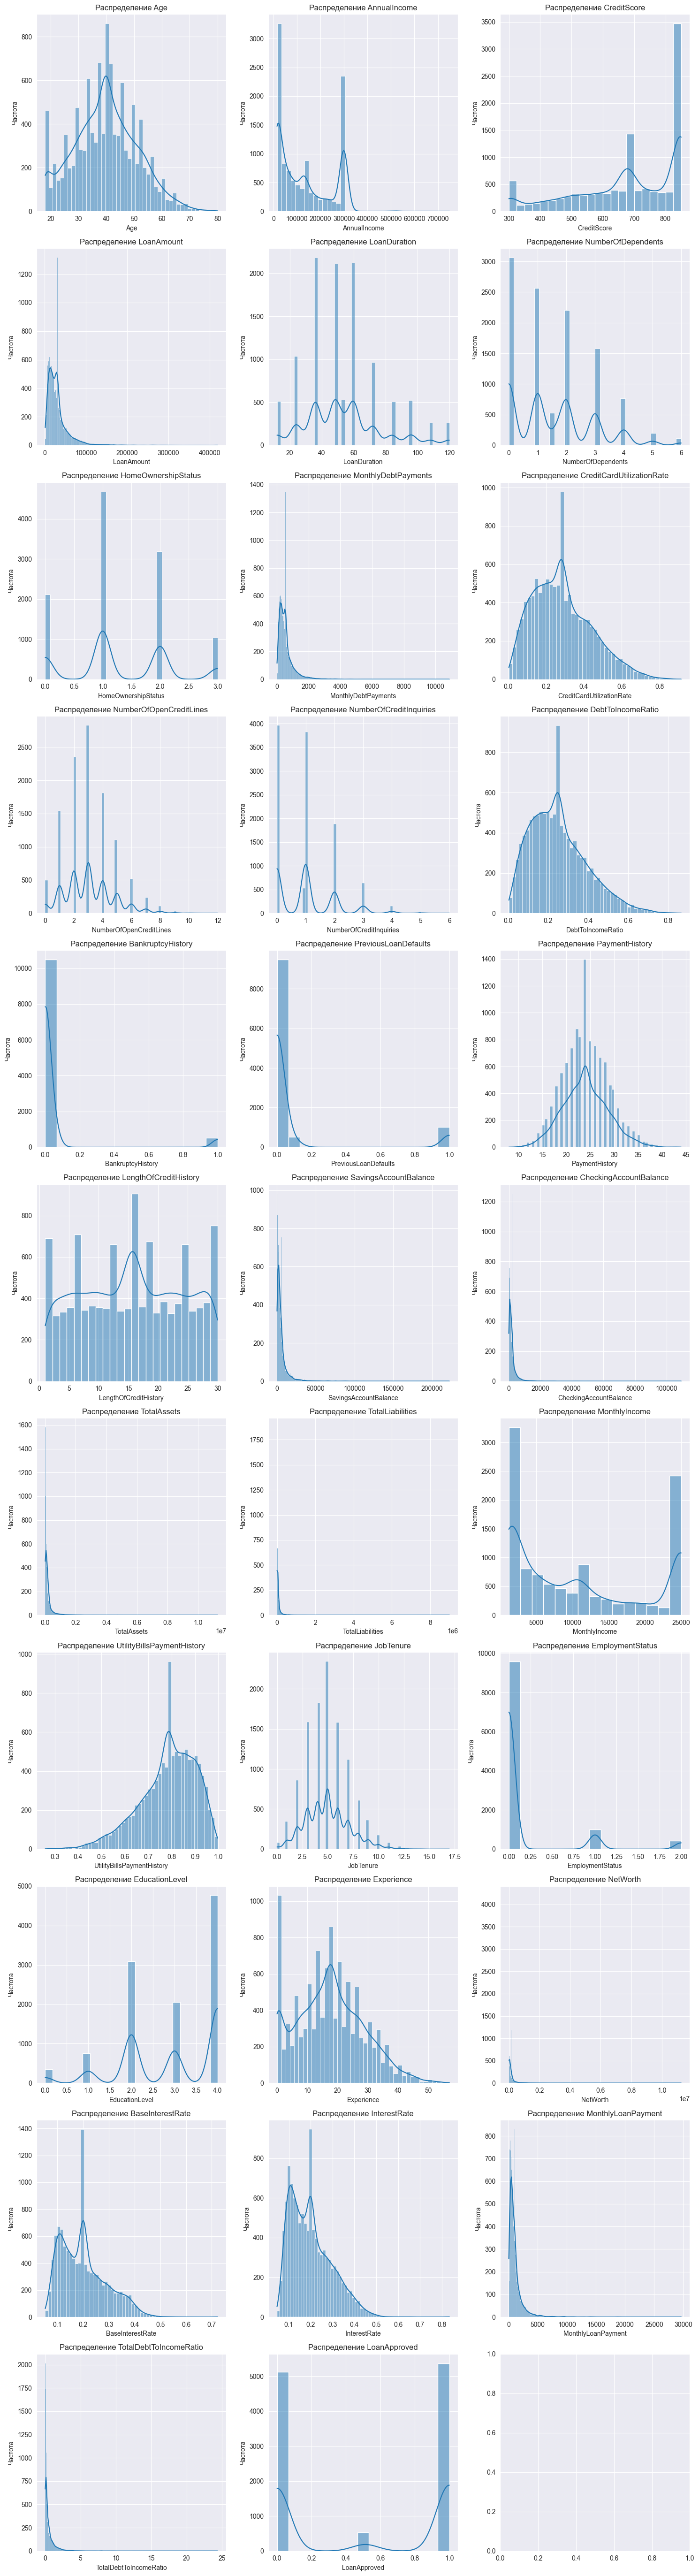

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numerical_features = df_filled.select_dtypes(include=['number']).columns

n_rows = len(numerical_features) // 3 + (len(numerical_features) % 3 > 0)
n_cols = 3

df_filled_copy = df_filled.copy()
df_filled_copy = df_filled_copy.drop(columns=["RiskScore"])

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features.drop("RiskScore")):
    print(i, feature)
    sns.histplot(df_filled_copy[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Частота')

for j in range(len(numerical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

у некоторых значений нормальное распределение. С другими что-нибудь придумаем. Есть очень большие значения, но их оч мало, нельзя назвать выбросами, убирать их не будем. А вот по RiskScore выбросы есть. Уберём с помощью квантили.

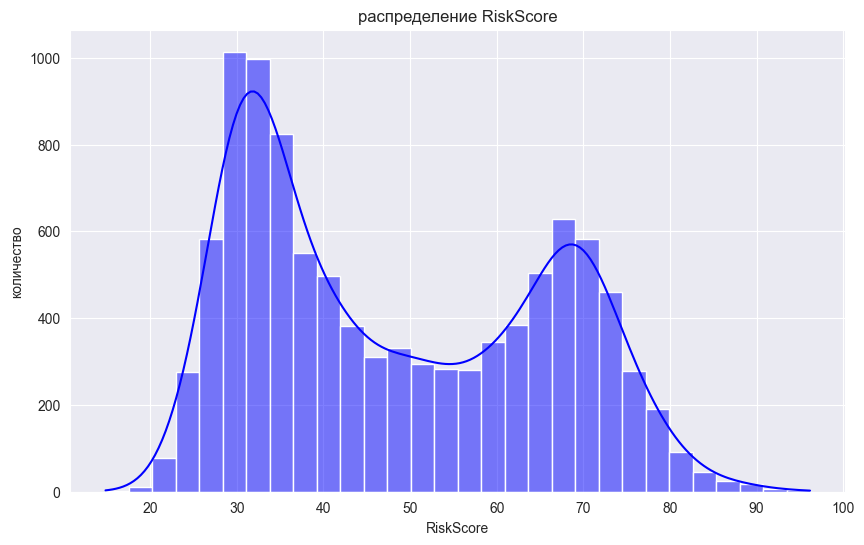

In [63]:
lower_bound = 0
upper_bound = df_filled['RiskScore'].quantile(0.99146)

df_filled_copy = df_filled[(df_filled['RiskScore'] >= lower_bound) & (df_filled['RiskScore'] <= upper_bound)].copy()

plt.figure(figsize=(10, 6))
sns.histplot(df_filled_copy['RiskScore'], bins=30, kde=True, color='blue')
plt.title('распределение RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('количество')
plt.show()


In [64]:
df_filled_copy['CreditScore_Log'] = np.log1p(df_filled_copy['CreditScore'])
df_filled_copy['CreditScore_Sqrt'] = np.sqrt(df_filled_copy['CreditScore'])
df_filled_copy['CreditScore_Cbrt'] = np.cbrt(df_filled_copy['CreditScore'])


# усиливает различия
df_filled_copy['CreditScore_sq2'] = df_filled_copy['CreditScore'] ** 2
df_filled_copy['CreditScore_sq3'] = df_filled_copy['CreditScore'] ** 3

In [65]:
features = ["AnnualIncome", "MonthlyLoanPayment", "LoanAmount", 'NetWorth', "TotalAssets"]

for feature in features:
    df_filled_copy[f'Log_{feature}'] = np.log1p(df_filled_copy[feature])

посмотрим на корреляции

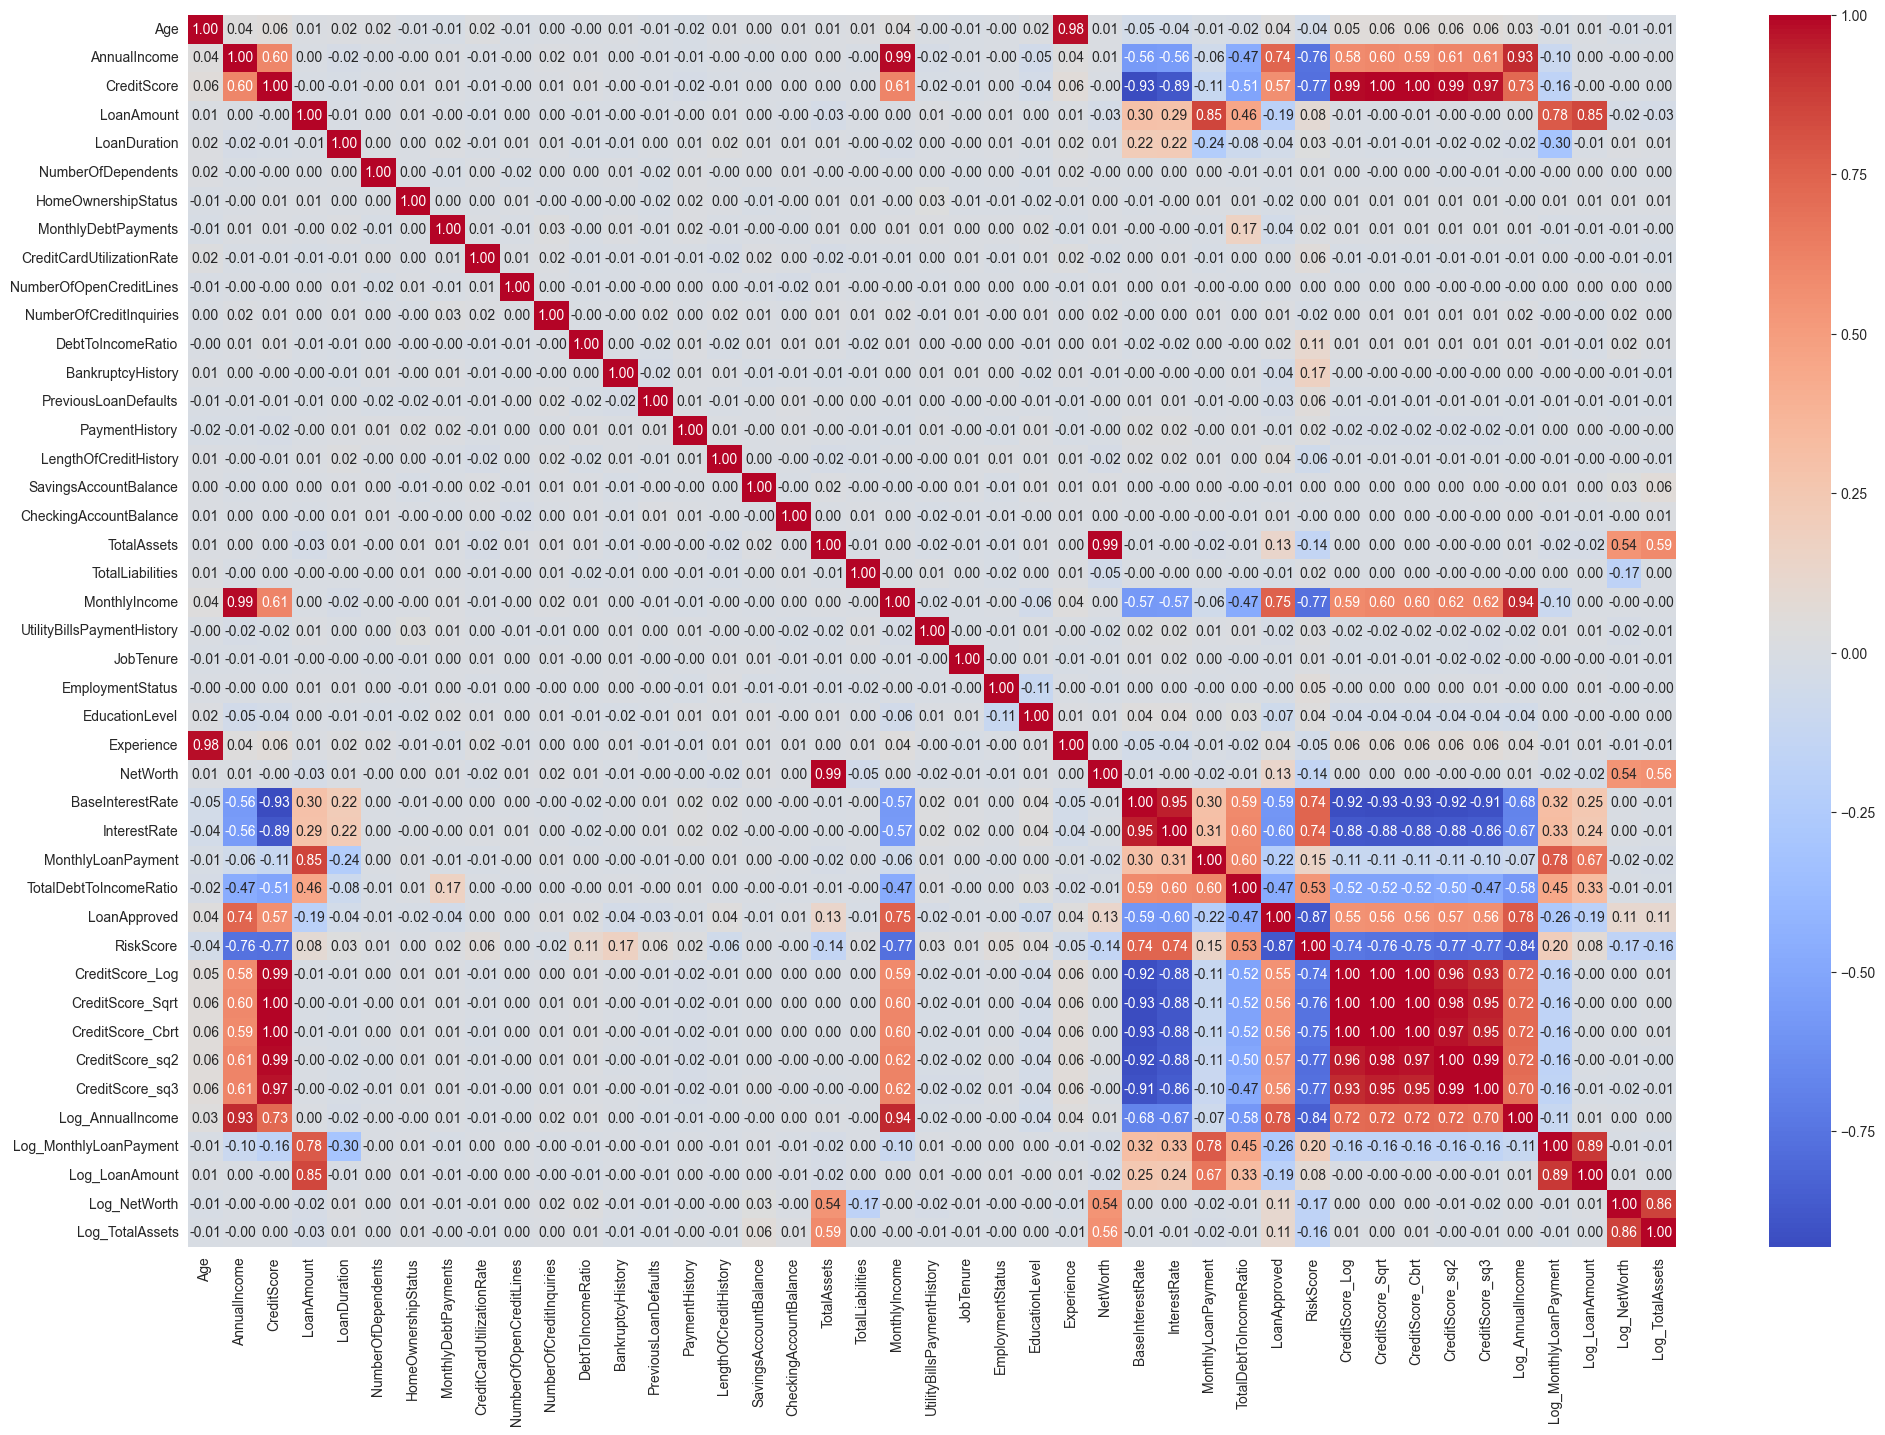

In [66]:
numeric_features = df_filled_copy.select_dtypes(include=[np.number])

correlation_matrix = numeric_features.corr()

plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm' , fmt='.2f')
plt.show()

In [67]:
df_n = df_filled_copy.select_dtypes("number").copy()
features = df_n.drop(columns=["RiskScore"])
target = df_n["RiskScore"]

features_z = z_score_normalization(features)[0]
df_n_z = features_z.copy()
df_n_z["RiskScore"] = target

In [68]:
from sklearn.metrics import mean_squared_error as mean_squared_error_sk

X = df_n_z.drop("RiskScore", axis=1).values
y = df_filled_copy["RiskScore"].values

model1 = LinearRegressionModel()
model1.fit(X, y, method="analytical")
predictions1 = model1.predict(X)
mse1 = mean_squared_error(predictions1, y)
smse1 = mean_squared_error_sk(predictions1, y)

model2 = LinearRegressionModel()
model2.fit(X, y, method="gradient", learning_rate=0.01, epochs=1000)
predictions2 = model2.predict(X)
mse2 = mean_squared_error(predictions2, y)
smse2 = mean_squared_error_sk(predictions2, y)

model3 = LinearRegressionModel()
model3.fit(X, y, method="stochastic", learning_rate=0.001, epochs=300)
predictions3 = model3.predict(X)
mse3 = mean_squared_error(predictions3, y)
smse3 = mean_squared_error_sk(predictions3, y)


print("MSE (Analytical):", mse1)
print("MSE (Gradient):", mse2)
print("MSE (Stochastic):", mse3)

print("sklearn MSE (Analytical):", smse1)
print("sklearn MSE (Gradient):", smse2)
print("sklearn MSE (Stochastic):", smse3)

MSE (Analytical): 12.568227257473179
MSE (Gradient): 15.95433481600702
MSE (Stochastic): 14.289715556977457
sklearn MSE (Analytical): 12.568227257473179
sklearn MSE (Gradient): 15.95433481600702
sklearn MSE (Stochastic): 14.289715556977457


проверим на реализации линейной регрессии из sklearn

In [69]:
from sklearn.linear_model import LinearRegression, SGDRegressor

X = df_n_z.drop("RiskScore", axis=1).values
y = df_filled_copy["RiskScore"].values

model_analytical = LinearRegression()
model_analytical.fit(X, y)
predictions_analytical = model_analytical.predict(X)
mse_analytical = mean_squared_error(predictions_analytical, y)
smse_analytical = mean_squared_error_sk(predictions_analytical, y)

model_gradient = SGDRegressor(max_iter=1000, learning_rate='adaptive', eta0=0.01, random_state=42)
model_gradient.fit(X, y)
predictions_gradient = model_gradient.predict(X)
mse_gradient = mean_squared_error(predictions_gradient, y)
smse_gradient = mean_squared_error_sk(predictions_gradient, y)

model_stochastic = SGDRegressor(max_iter=300, learning_rate='adaptive', eta0=0.001, random_state=42)
model_stochastic.fit(X, y)
predictions_stochastic = model_stochastic.predict(X)
mse_stochastic = mean_squared_error(predictions_stochastic, y)
smse_stochastic = mean_squared_error_sk(predictions_stochastic, y)

print("MSE (Analytical):", mse_analytical)
print("MSE (Gradient):", mse_gradient)
print("MSE (Stochastic):", mse_stochastic)

print("sklearn MSE (Analytical):", smse_analytical)
print("sklearn MSE (Gradient):", smse_gradient)
print("sklearn MSE (Stochastic):", smse_stochastic)

MSE (Analytical): 12.567451499625845
MSE (Gradient): 14.217841865030477
MSE (Stochastic): 14.606721868366625
sklearn MSE (Analytical): 12.567451499625845
sklearn MSE (Gradient): 14.217841865030477
sklearn MSE (Stochastic): 14.606721868366625


ну норм. теперь по мелочи по остальным заданиям. Сравним реализации метрик с sklearn-реализацями

In [70]:
from sklearn.metrics import mean_squared_error as mse_sklearn
from sklearn.metrics import mean_absolute_error as mae_sklearn
from sklearn.metrics import mean_absolute_percentage_error as mape_sklearn
from sklearn.metrics import r2_score as r2_sklearn

mse_custom = mean_squared_error(y, predictions1)
mae_custom = mean_absolute_error(y, predictions1)
mape_custom = mean_absolute_percentage_error(y, predictions1)
r2_custom = r2_score(y, predictions1)

mse_sk = mse_sklearn(y, predictions1)
mae_sk = mae_sklearn(y, predictions1)
mape_sk = mape_sklearn(y, predictions1) * 100
r2_sk = r2_sklearn(y, predictions1)

print(f"{'Metric':<10}{'Custom':<15}{'Sklearn':<15}{'Difference':<15}")
print(f"{'MSE':<10}{mse_custom:<15.4f}{mse_sk:<15.4f}{mse_custom - mse_sk:<15.4f}")
print(f"{'MAE':<10}{mae_custom:<15.4f}{mae_sk:<15.4f}{mae_custom - mae_sk:<15.4f}")
print(f"{'MAPE':<10}{mape_custom:<15.4f}{mape_sk:<15.4f}{mape_custom - mape_sk:<15.4f}")
print(f"{'R2':<10}{r2_custom:<15.4f}{r2_sk:<15.4f}{r2_custom - r2_sk:<15.4f}")

Metric    Custom         Sklearn        Difference     
MSE       12.5682        12.5682        0.0000         
MAE       2.7390         2.7390         0.0000         
MAPE      6.2664         6.2664         0.0000         
R2        0.9577         0.9577         0.0000         


теперь регуляризация

In [71]:
from abc import ABC, abstractmethod
import numpy as np

class Regularizer(ABC):
    @abstractmethod
    def penalty(self, weights):
        """Вычисляет штраф для весов."""
        pass

    @abstractmethod
    def gradient(self, weights):
        """Вычисляет градиент штрафа."""
        pass

class L2Regularizer(Regularizer):
    def __init__(self, alpha):
        self.alpha = alpha

    def penalty(self, weights):
        return self.alpha * np.sum(weights[1:] ** 2)

    def gradient(self, weights):
        grad = self.alpha * weights
        grad[0] = 0  # Bias не штрафуется
        return grad

class L1Regularizer(Regularizer):
    def __init__(self, alpha):
        self.alpha = alpha

    def penalty(self, weights):
        return self.alpha * np.sum(np.abs(weights[1:]))

    def gradient(self, weights):
        grad = self.alpha * np.sign(weights)
        grad[0] = 0  # Bias не штрафуется
        return grad

class ElasticNetRegularizer(Regularizer):
    def __init__(self, alpha, l1_ratio):
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def penalty(self, weights):
        l1_penalty = self.alpha * self.l1_ratio * np.sum(np.abs(weights[1:]))
        l2_penalty = 0.5 * self.alpha * (1 - self.l1_ratio) * np.sum(weights[1:] ** 2)
        return l1_penalty + l2_penalty

    def gradient(self, weights):
        l1_grad = self.alpha * self.l1_ratio * np.sign(weights)
        l2_grad = self.alpha * (1 - self.l1_ratio) * weights
        grad = l1_grad + l2_grad
        grad[0] = 0  # Bias не штрафуется
        return grad

class LpRegularizer(Regularizer):
    def __init__(self, alpha, p):
        self.alpha = alpha
        self.p = p

    def penalty(self, weights):
        return self.alpha * np.sum(np.abs(weights[1:]) ** self.p)

    def gradient(self, weights):
        grad = self.alpha * self.p * np.abs(weights) ** (self.p - 1) * np.sign(weights)
        grad[0] = 0  # Bias не штрафуется
        return grad

class RegularizedLinearRegressionModel:
    def __init__(self):
        self.weights = None

    def fit(self, X, y, method="analytical", learning_rate=0.01, epochs=1000, regularizer=None):
        X = self.add_bias(X)
        n_samples, n_features = X.shape

        if method == "analytical":
            if isinstance(regularizer, L2Regularizer):
                I = np.eye(n_features)
                I[0, 0] = 0  # Первый вес (bias) не штрафуется
                self.weights = np.linalg.inv(X.T @ X + regularizer.alpha * I) @ X.T @ y
            else:
                raise ValueError("Аналитический метод поддерживает только L2 регуляризацию.")

        elif method in ["gradient", "stochastic"]:
            self.weights = np.zeros(n_features)
            for epoch in range(epochs):
                if method == "gradient":
                    gradients = (1 / n_samples) * (X.T @ (X @ self.weights - y))
                elif method == "stochastic":
                    random_index = np.random.randint(n_samples)
                    xi = X[random_index:random_index + 1]
                    yi = y[random_index:random_index + 1]
                    gradients = 2 * xi.T @ (xi @ self.weights - yi).flatten()

                if regularizer:
                    gradients += regularizer.gradient(self.weights)

                self.weights -= learning_rate * gradients

        else:
            raise ValueError("Неверный метод. Выберите 'analytical', 'gradient' или 'stochastic'.")

    def predict(self, X):
        X = self.add_bias(X)
        return X @ self.weights

    def add_bias(self, X):
        return np.c_[np.ones(X.shape[0]), X]

Custom L2 MSE: 14.880189829891524 MAE: 3.01375786805119
Custom L1 MSE: 14.806118366786883 MAE: 3.0058006854378454
Custom ElasticNet MSE: 14.83610186403103 MAE: 3.0089052912911516
Custom Lp MSE: 18.76491259490959 MAE: 3.4118431645234715


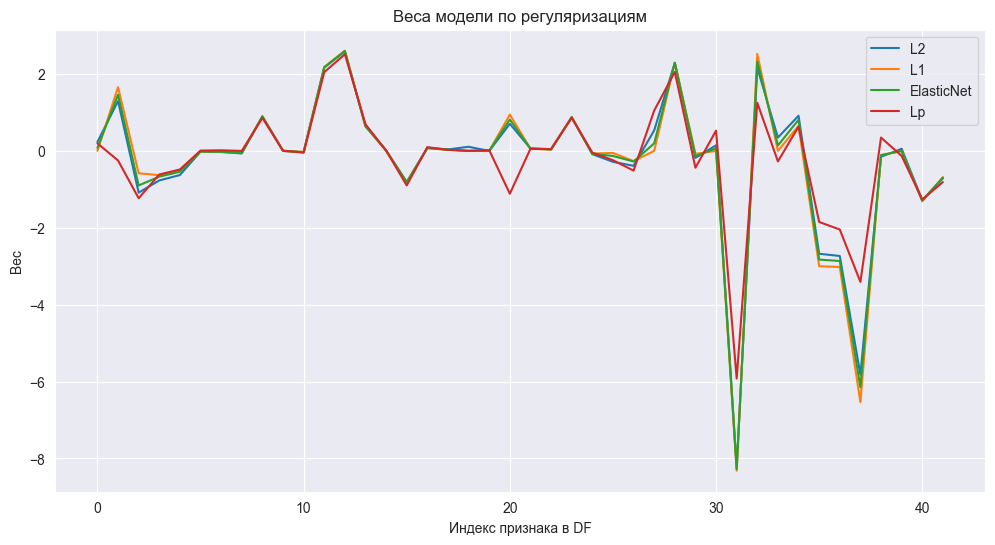

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

X = df_n_z.drop("RiskScore", axis=1).values
y = df_filled_copy["RiskScore"].values

def train_custom_model(regularizer):
    model = RegularizedLinearRegressionModel()
    model.fit(X, y, method="gradient", learning_rate=0.01, epochs=10000, regularizer=regularizer)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    return mse, mae, model.weights

l2_regularizer = L2Regularizer(alpha=0.01)
custom_mse_l2, custom_mae_l2, weights_l2 = train_custom_model(l2_regularizer)

l1_regularizer = L1Regularizer(alpha=0.01)
custom_mse_l1, custom_mae_l1, weights_l1 = train_custom_model(l1_regularizer)

elasticnet_regularizer = ElasticNetRegularizer(alpha=0.01, l1_ratio=0.5)
custom_mse_elasticnet, custom_mae_elasticnet, weights_elasticnet = train_custom_model(elasticnet_regularizer)

lp_regularizer = LpRegularizer(alpha=0.01, p=3)
custom_mse_lp, custom_mae_lp, weights_lp = train_custom_model(lp_regularizer)

print("Custom L2 MSE:", custom_mse_l2, "MAE:", custom_mae_l2)
print("Custom L1 MSE:", custom_mse_l1, "MAE:", custom_mae_l1)
print("Custom ElasticNet MSE:", custom_mse_elasticnet, "MAE:", custom_mae_elasticnet)
print("Custom Lp MSE:", custom_mse_lp, "MAE:", custom_mae_lp)

plt.figure(figsize=(12, 6))

names = ["L2", "L1", "ElasticNet", "Lp"]

weights_list = [weights_l2, weights_l1, weights_elasticnet, weights_lp]

for name, weights in zip(names, weights_list):
    plt.plot(weights[1:], label=name)  # Игнорируем bias (первый вес)

plt.title("Веса модели по регуляризациям")
plt.xlabel("Индекс признака в DF")
plt.ylabel("Вес")
plt.legend()
plt.show()

ну и повторяем все те же действия для тестового датасета.

In [73]:
test = pd.read_csv("test.csv")
test_ids = test["ID"].copy()


pre_test = test.copy()

home_ownership = {"Own" : 0, "Mortgage" : 1, "Rent" : 2, "Other" : 3}
employment_status = {"Employed" : 0, "Self-Employed" : 1, "Unemployed" : 2}
education_level = {"Doctorate" : 0, "Master" : 1, "Bachelor" : 2, "Associate" : 3, "High School" : 4}

pre_test["HomeOwnershipStatus"] = pre_test["HomeOwnershipStatus"].map(home_ownership)
pre_test["EmploymentStatus"] = pre_test["EmploymentStatus"].map(employment_status)
pre_test["EducationLevel"] = pre_test["EducationLevel"].map(education_level)


df_test = pre_test.copy()

df_test['CreditScore_Log'] = np.log1p(df_test['CreditScore'])
df_test['CreditScore_Sqrt'] = np.sqrt(df_test['CreditScore'])
df_test['CreditScore_Cbrt'] = np.cbrt(df_test['CreditScore'])

df_test['CreditScore_sq2'] = df_test['CreditScore'] ** 2
df_test['CreditScore_sq3'] = df_test['CreditScore'] ** 3

features = ["AnnualIncome", "MonthlyLoanPayment", "LoanAmount", 'NetWorth', "TotalAssets"]

for feature in features:
    df_test[f'Log_{feature}'] = np.log1p(df_test[feature])

df_test_n = df_test.select_dtypes("number").copy()
df_test_n_z = df_test_n.apply(lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1))
X_test = df_test_n_z.drop(columns=["ID"]).values

submission_df = pd.DataFrame({
    "ID": test_ids,
    "RiskScore": model1.predict(X_test)
})

submission_df.to_csv("submission_analytical.csv", index=False)

для посмотрим на выходные данные по модели из sklearn

In [74]:
from sklearn.linear_model import LinearRegression

sklearn_model = LinearRegression()
sklearn_model.fit(X, y)

submission_df = pd.DataFrame({
    "ID": test_ids,
    "RiskScore": sklearn_model.predict(X_test)
})

submission_df.to_csv("submission_sklearn.csv", index=False)